## Testing AUCell cell-level pathway activity scoring

In [1]:
from pathlib import Path
import os
import decoupler
import pandas as pd 
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np 
import scanpy as sc

In [2]:
# set GOI

GOI = 'CASP8'

In [3]:
# set a working directory
wdir = "/Users/samibening/Projects/Bachelor/"
os.chdir( wdir )

adata = sc.read_h5ad('data/output/adata.h5ad')
adata

AnnData object with n_obs × n_vars = 5397 × 16719
    obs: 'sampleID', 'barcode', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', '_scvi_batch', '_scvi_labels', 'leiden_res0_6', 'manual_celltype_annotation', 'celltypist_cell_label', 'celltypist_conf_score', 'celltypist_cell_label_coarse'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltypist_cell_label_coarse_colors', 'celltypist_cell_label_colors', 'hvg', 'leiden', 'leiden_res0_6_colors', 'neighbors', 'pca', 'sampleID_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'int_norm', 'log_int_norm', 'log_norm', 'norm', 'raw'
    obsp: 'connectivitie

In [4]:
# get reactome pathway data

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [5]:
reactome = gmt_to_decoupler("data/c2.cp.reactome.v2023.2.Hs.symbols.gmt")
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 300)]
reactome = reactome[reactome.geneset.isin(gsea_genesets)]

In [6]:
def clean_target_genes(row):
    return eval(row['TargetGenes'])

regulon = pd.read_csv(os.path.join(wdir, "SCENICfiles/reg.csv"))
regulon.apply(clean_target_genes, axis=1)

def get_regulon_genes(TF): # give TF name as string, e.g. 'KLF5'

    all_targets = regulon[regulon['TF'] == TF]['TargetGenes']
    df = pd.DataFrame()
    for i in all_targets:
        i = eval(i)
        df = pd.concat([df, pd.DataFrame(i)], axis=0)
        
    df = df.drop_duplicates()
    df = df.rename(columns={0: 'target', 1: 'importance'})
    df = df.sort_values(by='importance', ascending=False)
    df['TF'] = TF + "_REGULON"
    return df # returns a dataframe with all target genes and importance scores for a given TF

def get_regulon_genesets(regulon):
    df = pd.DataFrame()
    for TF in regulon['TF'].unique():
        df = pd.concat([df, get_regulon_genes(TF)], axis=0)
    df = df.drop(columns='importance')
    df = df.rename(columns={'target': 'genesymbol', 'TF': 'geneset'})
    # filter out geneset sizes that are too large or too small
    geneset_size = df.groupby("geneset").size()
    gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 300)]
    df = df[df.geneset.isin(gsea_genesets)]
    df = df.reset_index(drop=True)
    return df

regulon_genesets = get_regulon_genesets(regulon)

In [7]:
geneset_df = pd.concat([reactome, regulon_genesets], axis=0)
geneset_df = geneset_df.reset_index(drop=True)
geneset_df

,geneset,genesymbol
0,REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT,ABCA10
1,REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT,ABCA12
2,REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT,ABCA2
3,REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT,ABCA3
4,REACTOME_ABC_FAMILY_PROTEINS_MEDIATED_TRANSPORT,ABCA4
...,...,...
78602,ZNF518A_REGULON,SLC25A10
78603,ZNF518A_REGULON,ZFP3
78604,ZNF518A_REGULON,SCPEP1
78605,ZNF518A_REGULON,CBLN2


In [8]:
# run AUCell on REACTOME pathway and regulon genesets

decoupler.run_aucell(
    adata,
    geneset_df,
    source="geneset",
    target="genesymbol",
    use_raw=False,
)

In [9]:
# correlation between each pathways AUCell score and CASP8 expression (ONLY GENESETS AFTER FILTERING!!)
pathways_goi = geneset_df[(geneset_df['genesymbol'] == GOI)]

# get the AUCell scores for the genes in the pathway
goi_expression = adata.to_df()[GOI].values
def calc_correlation(column):
    return np.corrcoef(column, goi_expression)[0, 1]
pathways_goi.loc[:, 'correlation'] = adata.obsm['aucell_estimate'][pathways_goi['geneset']].apply(calc_correlation).values
pathways_goi = pathways_goi.sort_values('correlation', key=pd.Series.abs, ascending=False)
pathways_goi

,geneset,genesymbol,correlation
77200,MSC_REGULON,CASP8,0.264329
43485,REACTOME_REGULATION_OF_NF_KAPPA_B_SIGNALING,CASP8,0.203549
57823,REACTOME_TNFR1_INDUCED_PROAPOPTOTIC_SIGNALING,CASP8,0.201802
76663,IKZF3_REGULON,CASP8,0.199103
34222,REACTOME_NOD1_2_SIGNALING_PATHWAY,CASP8,0.198403
57997,REACTOME_TNF_SIGNALING,CASP8,0.167243
10749,REACTOME_DDX58_IFIH1_MEDIATED_INDUCTION_OF_INT...,CASP8,0.148978
35373,REACTOME_NUCLEOTIDE_BINDING_DOMAIN_LEUCINE_RIC...,CASP8,0.143081
5226,REACTOME_CASPASE_ACTIVATION_VIA_DEATH_RECEPTOR...,CASP8,0.142647
46512,REACTOME_RIPK1_MEDIATED_REGULATED_NECROSIS,CASP8,0.132642


In [18]:
# print gene set of specific regulon
ROI = 'TBP_REGULON'
print ('%s' % ' '.join(map(str, geneset_df[geneset_df['geneset'] == ROI]['genesymbol'].values)))

ZNF699 TRIM62 TBP OTUD6B DHX57 SETD4 ZEB2-AS1 S100P GDF9 FYCO1 UBXN10-AS1 PLCXD2 MORC2-AS1 PEG3 FRMD6 ITFG2 SLC16A1 SMOX LYRM9 DDIT3 IDO1 CDC20 BRINP3 ZSCAN29 LRFN5 C17orf80 KLRC1 TRAF2 KCNE3 SPATA18 CDKN3 F3 HECW2 CASP8 RAB4B SDF2L1 BCL2L14 SGPP2 GDF15 PRR16 DYNLL1 ETFBKMT CCDC3 SS18L2 OMA1 SYPL1 PSMD7 TPD52 FRYL CDC42EP5


In [10]:
top_pathways = list(pathways_goi['geneset'].values[:4])

adata.obs[top_pathways] = adata.obsm["aucell_estimate"][top_pathways]

/Users/samibening/micromamba/envs/gsea/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/samibening/micromamba/envs/gsea/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


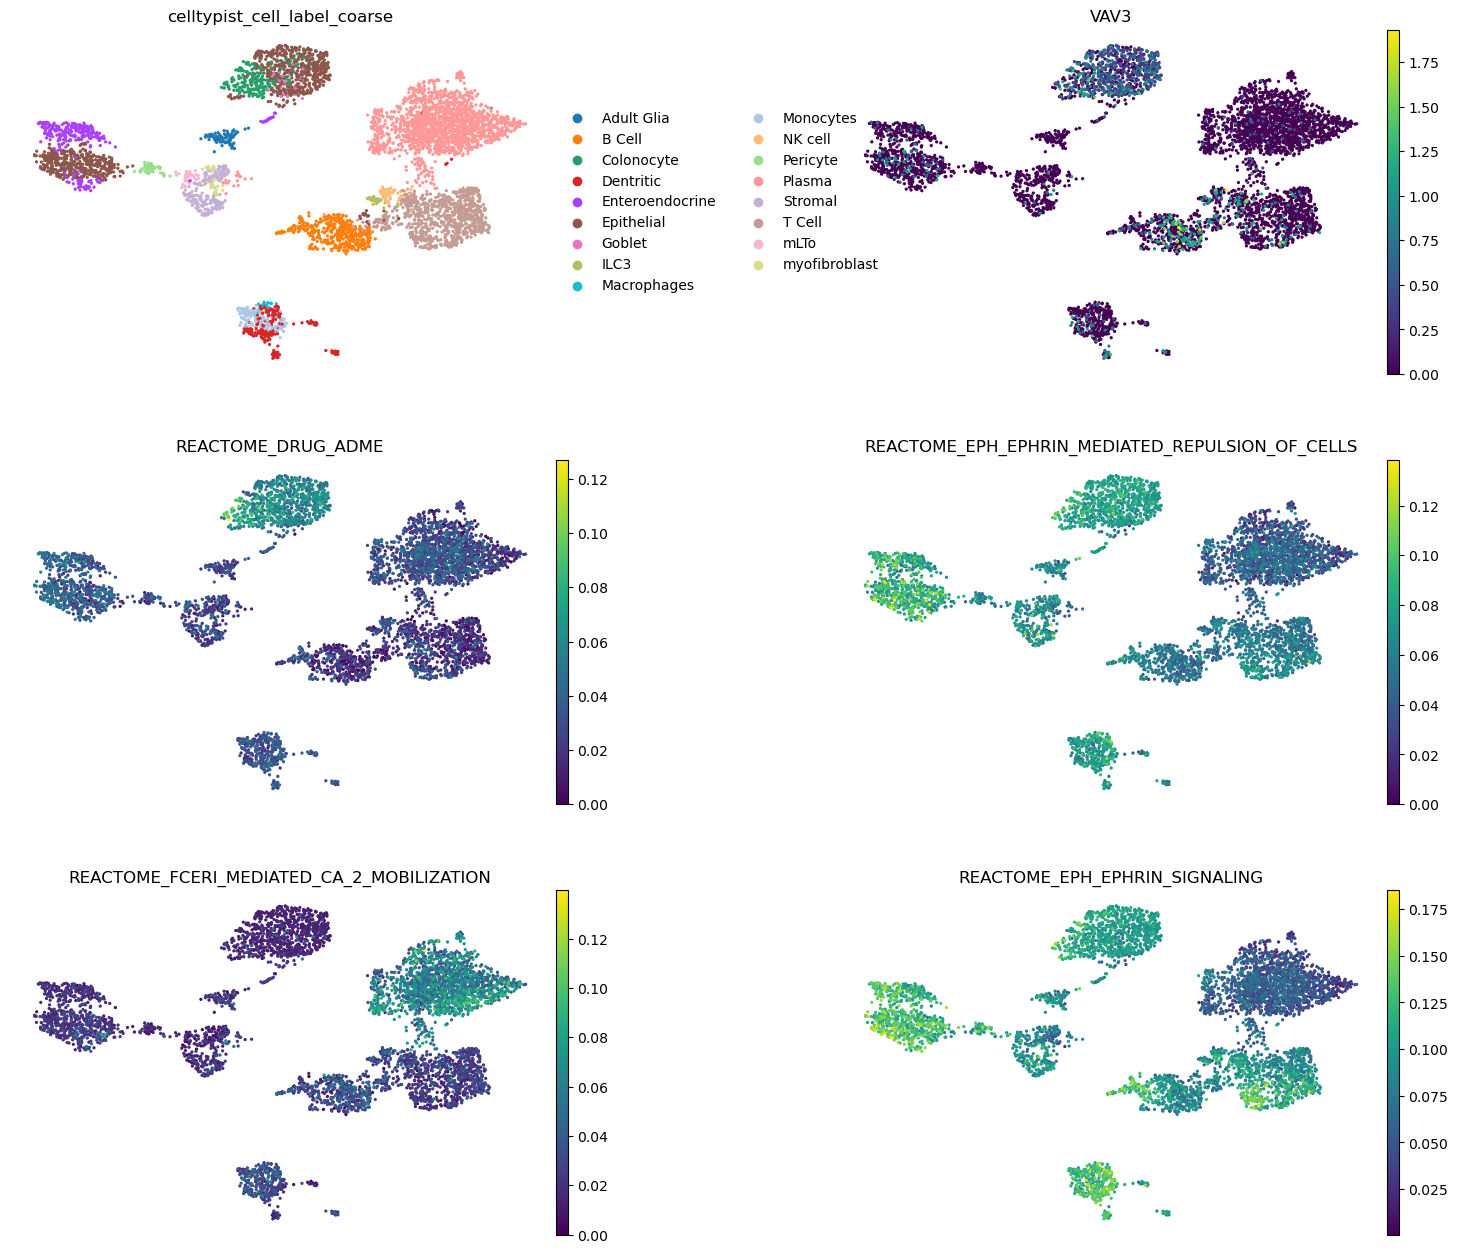

In [11]:
sc.pl.umap(
    adata,
    color=["celltypist_cell_label_coarse", GOI] + top_pathways,
    frameon=False,
    ncols=2,
    wspace=0.4,
)

# Regulon-level gene set enrichment analysis